# Data Challenge - Marubeni

### Submitted by: Saul Lee
### 2018-08-07

### Motivation:
Nearly a quarter of domestic flights in the U.S. are delayed or canceled; this costs your client,
American Airlines, billions of dollars per year. American Airlines’ executive leadership are
concerned about systemic inefficiencies that cause these delays and their impact on the public
perception of their brand versus their competitors.

### Goal: Analyze the data and provide actionable insights to the executive leadership at American Airlines
- Sources of the systematic inefficiencies that cause delays, recommendations to for mitigation
- Performance of AA versus other competitors

In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
import missingno as msno
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, recall_score, precision_score
import itertools
%matplotlib inline

In [112]:
# define helper functions

def encodePD(inPD):
    """encode the categorical columns in a data frame into numerical values
    
    """
    outPD = pd.DataFrame()
    for key,val in inPD.iteritems():
        # check if the column is numeric, if not, encode the data
        if inPD[key].dtype == 'O':
            outPD[key],_ = encoder(val)
        else:
            outPD[key] = val
    
    return outPD

def encoder(inArray):
    """purpose: encode categorical data into numerical values
    
    """
    le = LabelEncoder()
    le.fit(inArray)
    encoded = le.transform(inArray)
    
    return encoded,le

def checkRowsMissing(in_df):
    """checks a dataframe for number of n/a values"""
    
    num_rows,num_cols = in_df.shape
    bool_mat = pd.DataFrame.isna(in_df)
    
    if num_cols > 1:
        # sum in axis=0 direction to get the distribution with respect to columns
        print("Missing data distribution\n\n{}\n".format(np.sum(bool_mat,axis=0)))
    
    # sum in axis=1 direction to get the number of rows missing
    bool_mat = np.sum(bool_mat,axis=1)
    num_missing = np.count_nonzero(bool_mat)
    print("{} out of {} rows with missing data, about {:0.2f} %".format(num_missing,num_rows,num_missing/num_rows * 100))
    
    #return num_missing,bool_mat


def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ("0", "1"), rotation=45)
    plt.yticks(tick_marks, ("0", "1"))


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 1. Import data, clean, and preprocess

The flights data is contained in the csv file: 'flights.csv'

In [3]:
# read the data from the csv
raw_df = pd.read_csv('flights.csv')
raw_df.shape

/Users/sl1885/anaconda/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5819079, 31)

In [4]:
raw_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1 Check for missing values

Let's check and visualize the data for missing values.

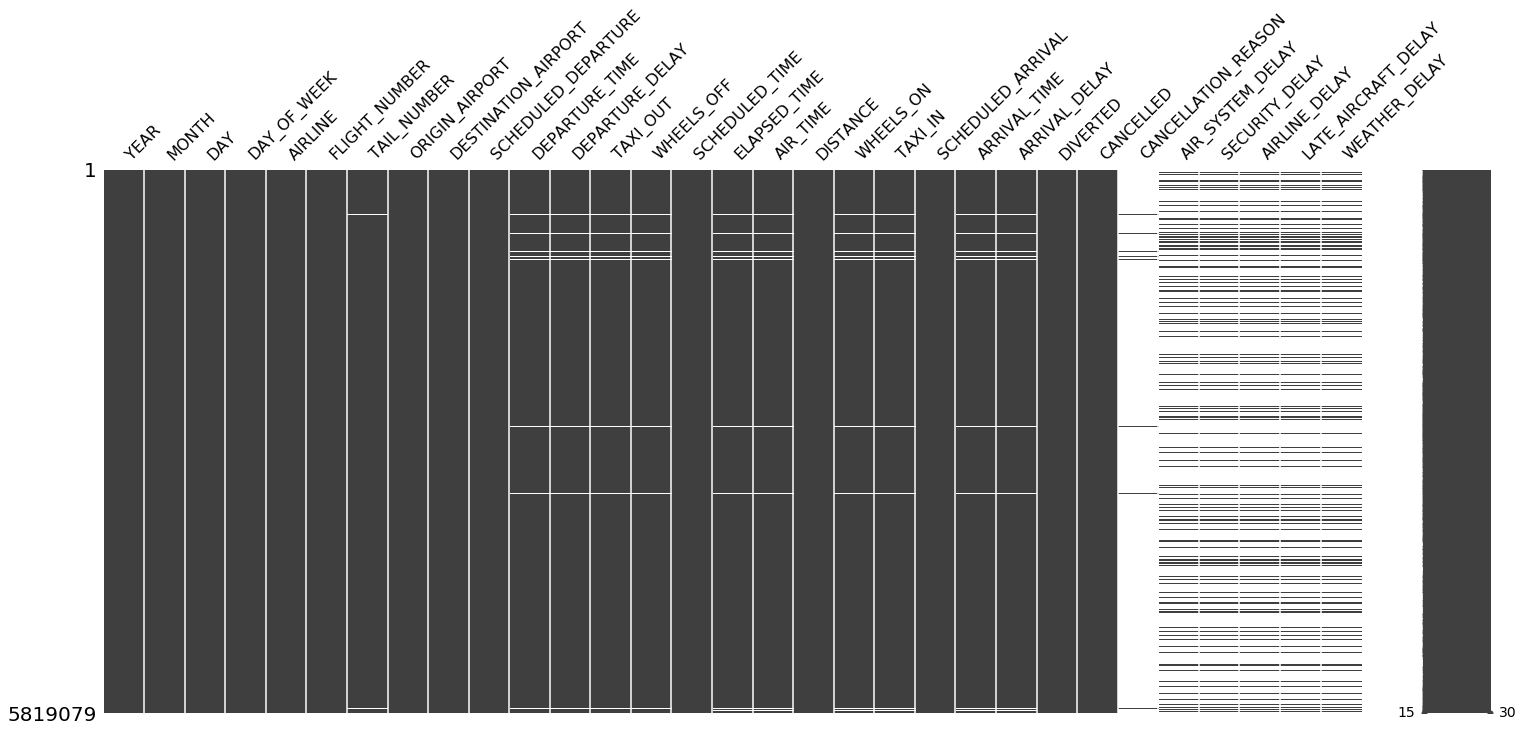

In [5]:
msno.matrix(raw_df)

In [6]:
# check for Data with N/A
checkRowsMissing(raw_df)

Missing data distribution

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

At a first glance, there are missing data in every row.  After visual inspection, this is due to the fact that there are 4 categories of flights (on-time/early, delayed, cancelled, or diverted).  Depending on the flight type, certain columns will be blank.  For example for an on-time/early flight, the columns "CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY" will be blank as the flight was not delayed or cancelled.  Conversely if a flight is cancelled, the columns "DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,TAXI_IN,ARRIVAL_TIME,ARRIVAL_DELAY" would be blank as a flight has not taken place.

### 1.2 Airport codes
Visual inspection of the airport codes in the ORIGIN_AIRPORT and DESTINATION_AIRPORT revealed that some of the airport codes are the usual 3 letter IATA codes, e.g. JFK, while some are 5-digit FAA Identification codes, e.g. 12478 for JFK.

After some web searching, I found two tables from the Bureau of Transportation Statistics with the information.
https://www.transtats.bts.gov/Fields.asp

- The first table 'L_AIRPORT_ID' contains the 5-digit airport ID along with the name of the airport
- The second table 'AIRPORT' contains the 3 letter airport code along with the name of the airport

We will load the tables in here and join the two together using the airport name as the matching ids.

In [163]:
# read in the airport id table
airport_id = pd.read_csv('L_AIRPORT_ID.csv')
airport_id.shape

(6471, 2)

In [263]:
airport_id.head()

,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"


In [166]:
# read in the airports table
airports = pd.read_csv('L_AIRPORT.csv')
airports.shape

(6489, 2)

In [167]:
airports.head()

,Code,Description
0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,04A,"Lik, AK: Lik Mining Camp"
3,05A,"Little Squaw, AK: Little Squaw Airport"
4,06A,"Kizhuyak, AK: Kizhuyak Bay"


In [202]:
airports_merged = airport_id.merge(airports,left_on='Description',right_on='Description',how='inner')
# drop duplicates in the airport_id
airports_merged = airports_merged.drop_duplicates('Code_x')
airports_merged = pd.Series(airports_merged['Code_y'].values,index=airports_merged['Code_x'].values.astype(str))
airports_merged.head()

10001    01A
10003    03A
10004    04A
10005    05A
10006    06A
dtype: object

In [271]:
converted_airports_origin[439091]

'SMF'

In [274]:
def mergeAirports(in_airports,airports_merged):
    """function to convert the airports with the 5-digit FAA id to 3 letter IATA codes

    in_airports is a Series of airport codes
    airports_merged is a Series containing the 5-digit code in the index and the 3 letter codes in the data
    """
    
    converted_airports = in_airports.astype(str)
    converted_airports = converted_airports.map(airports_merged)
    temp_bool = converted_airports.isna()

    temp_list = []
    for i,val in enumerate(temp_bool):
        if val == False:
            temp_list.append(converted_airports.loc[i])
        else:
            temp_list.append(in_airports.loc[i])
    
        if (i % 250000 == 0):
            print(i)
    print("Done i = {}".format(i))
    
    return temp_list

In [275]:
converted_airports_origin = mergeAirports(raw_df['ORIGIN_AIRPORT'],airports_merged)

0
250000
500000
750000
1000000
1250000
1500000
1750000
2000000
2250000
2500000
2750000
3000000
3250000
3500000
3750000
4000000
4250000
4500000
4750000
5000000
5250000
5500000
5750000
Done i = 5819078


In [278]:
converted_airports_destination = mergeAirports(raw_df['DESTINATION_AIRPORT'],airports_merged)

0
250000
500000
750000
1000000
1250000
1500000
1750000
2000000
2250000
2500000
2750000
3000000
3250000
3500000
3750000
4000000
4250000
4500000
4750000
5000000
5250000
5500000
5750000
Done i = 5819078


In [279]:
# add the converted airports to the raw_df dataframe
raw_df['ORIGIN_AIRPORT_fixed'] = converted_airports_origin
raw_df['DESTINATION_AIRPORT_fixed'] = converted_airports_destination

In [287]:
raw_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_AIRPORT_fixed,DESTINATION_AIRPORT_fixed
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,SEA
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,LAX,PBI
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SFO,CLT
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,LAX,MIA
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,SEA,ANC


In [281]:
# save the conversions to file, to save computation time
raw_df[['ORIGIN_AIRPORT_fixed','DESTINATION_AIRPORT_fixed']].to_csv('converted_airports.csv',index=False)

In [285]:
# go ahead and build a encoder for later use
_ , airport_encoder = encoder(converted_airports_origin)

In [286]:
len(airport_encoder.classes_)

324

### 1.3 Flight Types
Next let's examine the 'DIVERTED' and 'CANCELLED' flights.

In [288]:
# count the number of diverted flights
raw_df['DIVERTED'].value_counts()

0    5803892
1      15187
Name: DIVERTED, dtype: int64

In [289]:
# count the number of cancelled flights
raw_df['CANCELLED'].value_counts()

0    5729195
1      89884
Name: CANCELLED, dtype: int64

In [290]:
# count the number of flights where both the diverted and cancelled are 1
count = 0
for row in raw_df.itertuples():
    if row.DIVERTED == 1 and row.CANCELLED == 1:
        print(row[0])
        count += count

print("Number of Diverted and Cancelled Found where both are 1 = {}".format(count))

Number of Diverted and Cancelled Found where both are 1 = 0


In [291]:
# total number of diverted and cancelled flights
raw_df['DIVERTED'].value_counts().loc[1] + raw_df['CANCELLED'].value_counts().loc[1]

105071

In [292]:
# check the 6 missing values SCHEDULED_TIME
raw_df[raw_df['SCHEDULED_TIME'].isna()]

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_AIRPORT_fixed,DESTINATION_AIRPORT_fixed
483174,2015,2,1,7,NK,416,N627NK,FLL,IAG,2215,...,0,1,B,NaN,NaN,NaN,NaN,NaN,FLL,IAG
619941,2015,2,10,2,NK,416,N632NK,FLL,IAG,2215,...,0,1,B,NaN,NaN,NaN,NaN,NaN,FLL,IAG
1720237,2015,4,20,1,NK,174,N630NK,FLL,LGA,1602,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,FLL,LGA
1820960,2015,4,26,7,NK,720,N614NK,DEN,DFW,2059,...,0,1,B,NaN,NaN,NaN,NaN,NaN,DEN,DFW
2031482,2015,5,9,6,NK,324,N620NK,MCO,ACY,2130,...,0,1,B,NaN,NaN,NaN,NaN,NaN,MCO,ACY
2034453,2015,5,10,7,NK,368,N534NK,ORD,BWI,825,...,0,1,C,NaN,NaN,NaN,NaN,NaN,ORD,BWI


In [293]:
# check the number of flights with missing TAIL_NUMBER are cancelled flights
raw_df[raw_df['TAIL_NUMBER'].isna()]['CANCELLED'].value_counts()

1    14721
Name: CANCELLED, dtype: int64

There are 15187 diverted (designated by a value of 1 in the 'DIVERTED' column) and 89884 cancelled (designated by a value of 1 in the 'CANCELLED' column) flights which account for 0.3 % and 1.5 %, respectively.  Further checking for the rows with missing 'TAIL_NUMBER' values are all confirms that they are all cancelled flights.  The 6 rows with missing values in SCHEDULED_TIME are either cancelled or diverted flights.

Since the flights can be separated into three different groups (on-time/delayed/early,cancelled,diverted) with different data compositions, it makes sense to split the original data frame into 3 sub data frames

In [294]:
# split the dataframe for diverted
df_diverted = raw_df[raw_df['DIVERTED'] == 1]
df_diverted.shape

(15187, 33)

In [295]:
# split the dataframe cancelled
df_cancelled = raw_df[raw_df['CANCELLED'] == 1]
df_cancelled.shape

(89884, 33)

In [296]:
# split the dataframe
df_delayed = raw_df[(raw_df['CANCELLED'] == 0).values & (raw_df['DIVERTED'] == 0).values]
df_delayed.shape

(5714008, 33)

### 1.2 Flight Delays

Since the diverted and cancelled flights account for very small percentage of the total flights in 2015, let's examine the flight delay data frame first.

In [297]:
# check again for Data with N/A
checkRowsMissing(df_delayed)

Missing data distribution

YEAR                               0
MONTH                              0
DAY                                0
DAY_OF_WEEK                        0
AIRLINE                            0
FLIGHT_NUMBER                      0
TAIL_NUMBER                        0
ORIGIN_AIRPORT                     0
DESTINATION_AIRPORT                0
SCHEDULED_DEPARTURE                0
DEPARTURE_TIME                     0
DEPARTURE_DELAY                    0
TAXI_OUT                           0
WHEELS_OFF                         0
SCHEDULED_TIME                     0
ELAPSED_TIME                       0
AIR_TIME                           0
DISTANCE                           0
WHEELS_ON                          0
TAXI_IN                            0
SCHEDULED_ARRIVAL                  0
ARRIVAL_TIME                       0
ARRIVAL_DELAY                      0
DIVERTED                           0
CANCELLED                          0
CANCELLATION_REASON          5714008
AIR_SYSTEM_

The missing values are only in the columns "CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY"

We can now begin to drop non-relevant/unnecessary data columns

- DIVERTED, CANCELLED and CANCELLATION_REASON: these are not necssary since non of the flights in this data frame are from diverted or cancelled flights
- ELAPSED_TIME: from the definition ELAPSED_TIME is a combination of AIR_TIME+TAXI_IN+TAXI_OUT which is correlated with other those columns

In [298]:
df_delayed = df_delayed.drop(['DIVERTED','CANCELLED',
                              'CANCELLATION_REASON',
                              'ELAPSED_TIME','ORIGIN_AIRPORT','DESTINATION_AIRPORT'],axis=1)
df_delayed.shape

(5714008, 27)

In [299]:
# check again for Data with N/A
checkRowsMissing(df_delayed)

Missing data distribution

YEAR                               0
MONTH                              0
DAY                                0
DAY_OF_WEEK                        0
AIRLINE                            0
FLIGHT_NUMBER                      0
TAIL_NUMBER                        0
SCHEDULED_DEPARTURE                0
DEPARTURE_TIME                     0
DEPARTURE_DELAY                    0
TAXI_OUT                           0
WHEELS_OFF                         0
SCHEDULED_TIME                     0
AIR_TIME                           0
DISTANCE                           0
WHEELS_ON                          0
TAXI_IN                            0
SCHEDULED_ARRIVAL                  0
ARRIVAL_TIME                       0
ARRIVAL_DELAY                      0
AIR_SYSTEM_DELAY             4650569
SECURITY_DELAY               4650569
AIRLINE_DELAY                4650569
LATE_AIRCRAFT_DELAY          4650569
WEATHER_DELAY                4650569
ORIGIN_AIRPORT_fixed               0
DESTINATION

For the remaining missing values in the columns "AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY", let's assume those are flights that are not delayed.  We can fill those values in with zeros.

In [300]:
df_delayed = df_delayed.fillna(0)

Lets generate the target labels.  We will define delayed flight as flights that have ARRIVAL_TIME > 0.

For all flights, 63.48 % of the flights are on-time/early, 36.52 % of the flights are delayed


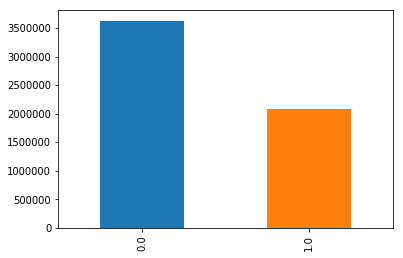

In [301]:
y_labels = (df_delayed['ARRIVAL_DELAY'] > 0).astype(float)
counts = y_labels.value_counts()
counts.plot.bar()
print("For all flights, {:.2f} % of the flights are on-time/early, {:.2f} % of the flights are delayed".format( 
      (counts.loc[0.0]/y_labels.shape[0]*100),\
     (counts.loc[1.0]/y_labels.shape[0]*100)))

For AA flights, 64.63 % of the flights are on-time/early, 35.37 % of the flights are delayed


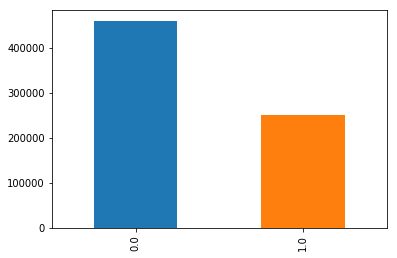

In [302]:
df_delayed_AA = df_delayed[df_delayed['AIRLINE'] == 'AA']
y_labels_AA = y_labels[df_delayed['AIRLINE'] == 'AA']
counts = y_labels_AA.value_counts()
counts.plot.bar()
print("For AA flights, {:.2f} % of the flights are on-time/early, {:.2f} % of the flights are delayed".format( 
      (counts.loc[0.0]/y_labels_AA.shape[0]*100),\
     (counts.loc[1.0]/y_labels_AA.shape[0]*100)))

In [303]:
df_delayed_AA.shape

(712935, 27)

For non AA flights, 63.31 % of the flights are on-time/early, 36.69 % of the flights are delayed


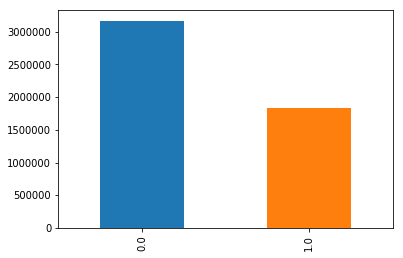

In [304]:
df_delayed_other = df_delayed[df_delayed['AIRLINE'] != 'AA']
y_labels_other = y_labels[df_delayed['AIRLINE'] != 'AA']
counts = y_labels_other.value_counts()
counts.plot.bar()
print("For non AA flights, {:.2f} % of the flights are on-time/early, {:.2f} % of the flights are delayed".format( 
      (counts.loc[0.0]/y_labels_other.shape[0]*100),\
     (counts.loc[1.0]/y_labels_other.shape[0]*100)))

Since we are mainly interested in American Airline flights and there is not a big difference in the on-time rate versus non-American Airlines flights, we will focus just on the data for American Airlines.

### 1.3 Preprocessing and Feature Engineering

It will be helpful to define a few additional features:

It is useful to have the dates of the year.  However, the following features may be useful with respect to flight delays:
- proximity to federal holidays such as
    - New Year's Day (2015-01-01)
    - MLK Holiday (2015-01-19)
    - President's Day (2015-02-16)
    - Memorial Day (2015-05-25)
    - Independence Day (2015-07-04)
    - Labor Day (2015-09-07)
    - Columbus Day (2015-10-12)
    - Veteran's Day (2015-11-11)
    - Thanksgiving (2015-11-26)
    - Christmas (2015-12-25)

In [367]:
# pre-saved the dates in a csv file
holidays_df = pd.read_csv('federal_holidays.csv')
holidays_df.head()

,Name,Year,Month,Day
0,New Year's Day,2015,1,1
1,MLK Holiday,2015,1,19
2,President's Day,2015,2,16
3,Memorial Day,2015,5,25
4,Independence Day,2015,7,4


In [381]:
df_delayed[df_delayed['MONTH'] == 2].iloc[0].name

469968

In [384]:
# generate new datetime object column
df_delayed['DATE'] = pd.to_datetime(df_delayed[['YEAR','MONTH','DAY']])

In [386]:
holidays_df['DATE'] = pd.to_datetime(holidays_df[['Year','Month','Day']])
holidays_df.head()

,Name,Year,Month,Day,DATE
0,New Year's Day,2015,1,1,2015-01-01
1,MLK Holiday,2015,1,19,2015-01-19
2,President's Day,2015,2,16,2015-02-16
3,Memorial Day,2015,5,25,2015-05-25
4,Independence Day,2015,7,4,2015-07-04


In [398]:
from datetime import timedelta
(holidays_df['DATE'] < holidays_df['DATE'].loc[0] + timedelta(days=1)).astype(int)

0    1
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: DATE, dtype: int64

In [485]:
def dayMarker(in_date,in_PD,offset=0):
    """function to marker a row to 1 if the date matches in_date
    
    in_date = datetime object containing the date of interest
    in_PD = Series or DataFrame where the date is contained within a column 'DATE'
    """
    if offset ==0:
        out_col = (in_PD['DATE'] == in_date).astype(int)
    else:
        offset=abs(offset)
        out_col = ((in_PD['DATE'] != in_date).values & \
                   (in_PD['DATE'] >= in_date - timedelta(days=offset)).values & \
                   (in_PD['DATE'] <= in_date + timedelta(days=offset)).values).astype(int)
    
    return out_col

def holidayMarker(in_holidays_PD,in_PD,offset_days=[0]):
    """function to mark holidays
    
    in_holidays_PD = DataFrame where the holidays are stored in a column 'DATE'
    in_PD = Series or DataFrame where the date is contained within a column 'DATE'
    offset_days = list containing days around the holiday to check for, default is zero
    """
    
    out_Array = np.zeros((in_PD.shape[0],len(offset_days)))
    
    for i,row in in_holidays_PD.iterrows():
        cur_date = row['DATE']
        for j,cur_offset in enumerate(offset_days):
            out_Array[:,j] = out_Array[:,j] + dayMarker(cur_date,in_PD,cur_offset)
    
    return out_Array

Create a few new columns
- on_holiday, on the holiday
- days_before_3, within 3 days advance of the holiday
- days_after_3, within 3 days after the holiday

In [486]:
holiday_Array = holidayMarker(holidays_df,df_delayed,[0,3,5])

In [487]:
df_delayed['Holiday'] = holiday_Array[:,0]
df_delayed['Holiday_3'] = holiday_Array[:,1]
df_delayed['Holiday_5'] = holiday_Array[:,2]

Convert categorical data to encoded numerical data

In [305]:
df_delayed.dtypes

YEAR                           int64
MONTH                          int64
DAY                            int64
DAY_OF_WEEK                    int64
AIRLINE                       object
FLIGHT_NUMBER                  int64
TAIL_NUMBER                   object
SCHEDULED_DEPARTURE            int64
DEPARTURE_TIME               float64
DEPARTURE_DELAY              float64
TAXI_OUT                     float64
WHEELS_OFF                   float64
SCHEDULED_TIME               float64
AIR_TIME                     float64
DISTANCE                       int64
WHEELS_ON                    float64
TAXI_IN                      float64
SCHEDULED_ARRIVAL              int64
ARRIVAL_TIME                 float64
ARRIVAL_DELAY                float64
AIR_SYSTEM_DELAY             float64
SECURITY_DELAY               float64
AIRLINE_DELAY                float64
LATE_AIRCRAFT_DELAY          float64
WEATHER_DELAY                float64
ORIGIN_AIRPORT_fixed          object
DESTINATION_AIRPORT_fixed     object
d

In [497]:
# convert categorical data to encoded values
df_delayed['AIRLINE_enc'], AIRLINE_encoder = encoder(df_delayed['AIRLINE'])
df_delayed['TAIL_NUMBER_enc'], TAIL_NUMBER_encoder = encoder(df_delayed['TAIL_NUMBER'])

In [498]:
# we already have an encoder for the AIRPORT.  we will use the same one so the codes are the same
df_delayed['ORIGIN_AIRPORT_enc'] = airport_encoder.transform(df_delayed['ORIGIN_AIRPORT_fixed'].values)

In [499]:
df_delayed['DESTINATION_AIRPORT_enc'] = airport_encoder.transform(df_delayed['DESTINATION_AIRPORT_fixed'].values)

In [500]:
df_delayed_AA = df_delayed[df_delayed['AIRLINE'] == 'AA']
X_delayed_AA = df_delayed_AA.drop(['AIRLINE',
                                   'TAIL_NUMBER',
                                   'ORIGIN_AIRPORT_fixed',
                                   'DESTINATION_AIRPORT_fixed',
                                   'ARRIVAL_DELAY',
                                   'DEPARTURE_DELAY',
                                    'DATE'],axis=1)

In [501]:
X_delayed_AA.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'ORIGIN_AIRPORT_enc', 'DESTINATION_AIRPORT_enc',
       'Holiday', 'Holiday_3', 'Holiday_5', 'AIRLINE_enc', 'TAIL_NUMBER_enc'],
      dtype='object')

## 2. Data visualization

Let's visualize the data:

In [26]:
# plot the number of employed and quits
raw_df['still_employed'].value_counts().plot.bar()
raw_df['still_employed'].value_counts()

KeyError: 'still_employed'

The distribution of the employees that have quit and still employeed is relatively balanced in the data set.

1     8408
2     4180
3     2724
4     2042
5     1740
6     1276
7     1209
8     1032
9      954
10     859
12      23
11      16
Name: company_id, dtype: int64

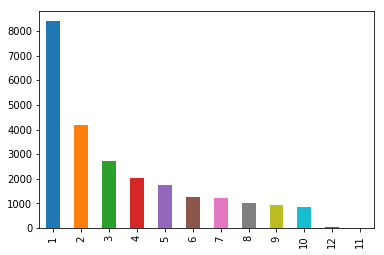

In [146]:
# lets examine the employees
raw_df['company_id'].value_counts().plot.bar()
raw_df['company_id'].value_counts()

customer_service    9089
engineer            4569
data_science        3157
sales               3148
marketing           3133
design              1367
Name: dept, dtype: int64

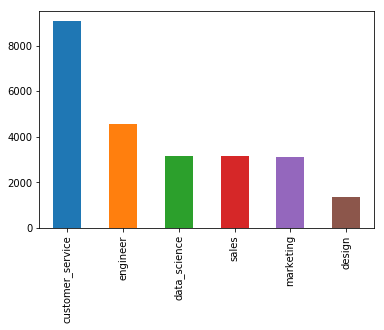

In [147]:
# lets examine the employees
raw_df['dept'].value_counts().plot.bar()
raw_df['dept'].value_counts()

Most of the employees in the data is from company 1, and customer service has the most employees.

Let's examine employees that have quit.  First we will create a new dataframe with just the employees that are no longer at the company.

In [148]:
quits_df = raw_df[raw_df['still_employed'] == 0]

Next we will groupby various columns in the data to visualize the distribution and the effect of the column on the length of employment.

In [231]:
# lets examine the company id
grouped_company = quits_df.groupby(['company_id'])['length_at_company']

Text(0.5,0,'Length of Time before Quitting (Days)')

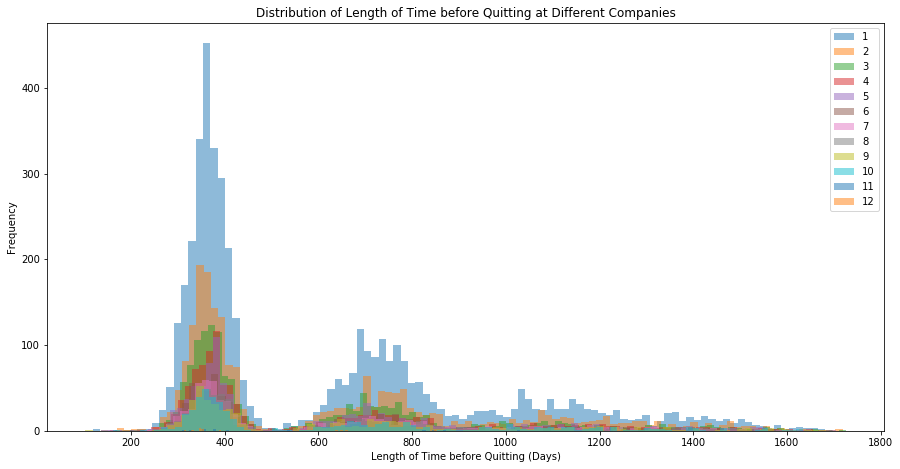

In [232]:
grouped_company.plot.hist(bins=100,stacked=True,alpha=0.5,figsize=(15,7.5))
plt.legend()
plt.title('Distribution of Length of Time before Quitting at Different Companies')
plt.xlabel('Length of Time before Quitting (Days)')

All of the companies show similar length at company trends.  The strongest peak is around 365 days with the second grouping peaking at around 730 days.  The peaks are higher at company one because they also have more employees in the data.

Next we will see the effect of dept variable

In [182]:
# lets examine the employees
grouped_dept = quits_df.groupby(['dept'])['length_at_company']

Text(0.5,0,'Length of Time before Quitting (Days)')

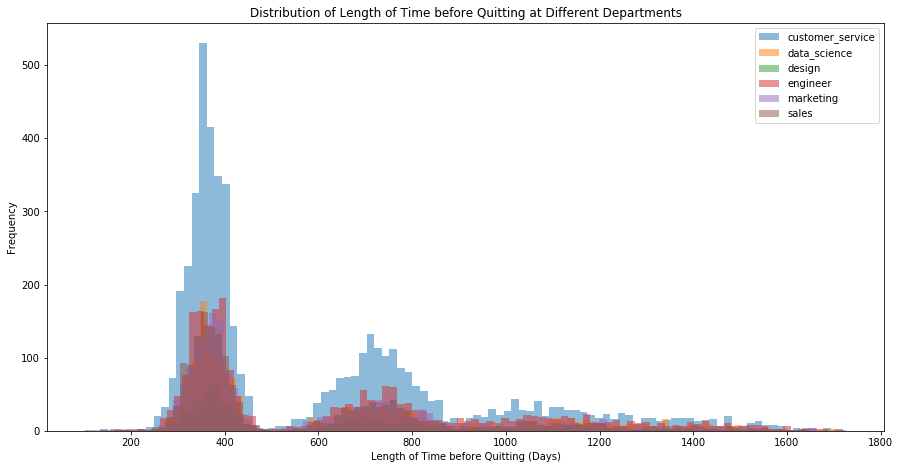

In [187]:
grouped_dept.plot.hist(bins=100,stacked=True,alpha=0.5,figsize=(15,7.5))
plt.legend()
plt.title('Distribution of Length of Time before Quitting at Different Departments')
plt.xlabel('Length of Time before Quitting (Days)')

In [221]:
quits_df['seniority_binned'] = pd.cut(quits_df['seniority'],bins=[0,5,10,15,20,25,30,100],retbins=False)

/Users/sl1885/anaconda/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [222]:
# lets examine the employees
grouped_seniority = quits_df.groupby(['seniority_binned'])['length_at_company']

Text(0.5,0,'Length of Time before Quitting (Days)')

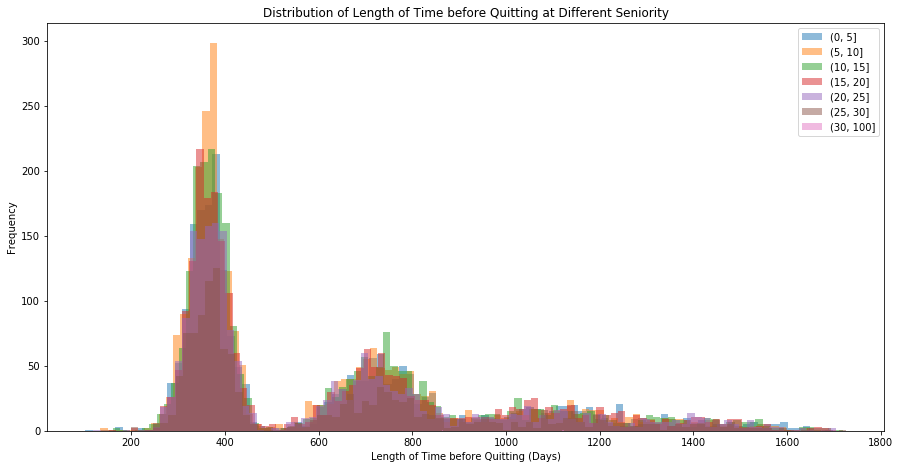

In [223]:
grouped_seniority.plot.hist(bins=100,stacked=True,alpha=0.5,figsize=(15,7.5))
plt.legend()
plt.title('Distribution of Length of Time before Quitting at Different Seniority')
plt.xlabel('Length of Time before Quitting (Days)')

In [228]:
# let's bin the salary
quits_df['salary_binned'] = pd.cut(quits_df['salary'],bins=[0,25000,50000,75000,100000,200000,1000000],retbins=False)

/Users/sl1885/anaconda/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [229]:
# lets examine the employees
grouped_salary = quits_df.groupby(['salary_binned'])['length_at_company']

Text(0.5,0,'Length of Time before Quitting (Days)')

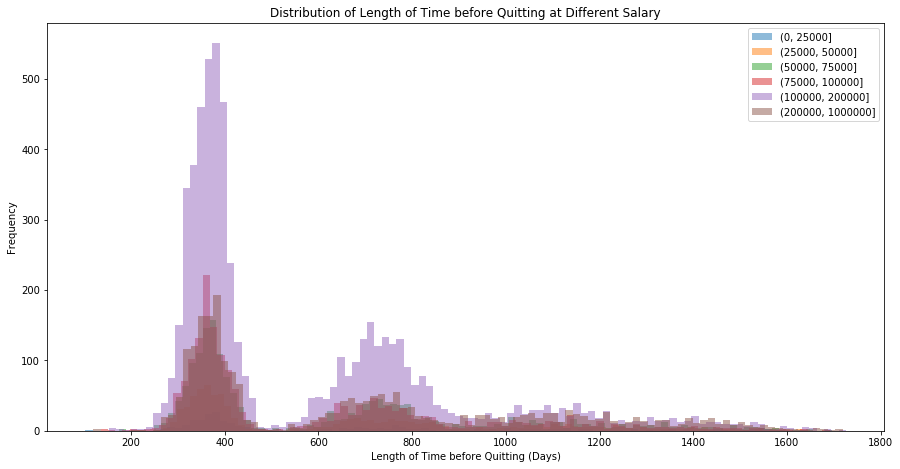

In [230]:
grouped_salary.plot.hist(bins=100,stacked=True,alpha=0.5,figsize=(15,7.5))
plt.legend()
plt.title('Distribution of Length of Time before Quitting at Different Salary')
plt.xlabel('Length of Time before Quitting (Days)')

Similary to the company plot, grouping by department,seniority, and salary show similar length at company trends.  The strongest peak is around 365 days with the second grouping peaking at around 730 days.  The peaks are higher at company one because they also have more employees in the data.

## 3. Model Fitting: Delayed Flights


In [591]:
# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X_delayed_AA,np.array(y_labels_AA),
                                                    test_size = 0.25,
                                                    random_state = 42)

In [592]:
# balance the classes in the training set, subsample the negative class to match the number of positive class
composite = X_train
composite['labels'] = y_train.reshape(-1,1)

/Users/sl1885/anaconda/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [593]:
composite_negative = composite[composite['labels'] == 0]
composite_negative.shape

(345393, 29)

In [594]:
composite_positive = composite[composite['labels'] == 1]
composite_positive.shape

(189308, 29)

In [595]:
from sklearn.utils import resample
n_samples = composite_positive.shape[0]
composite_negative_ds = resample(composite_negative,
                       replace=False,
                       n_samples=n_samples,
                       random_state =10
                      )
composite_negative_ds.shape

(189308, 29)

In [596]:
composite_ds = pd.concat([composite_negative_ds,composite_positive])
X_train = np.array(composite_ds.drop('labels',axis=1))
y_train = np.array(composite_ds['labels'])

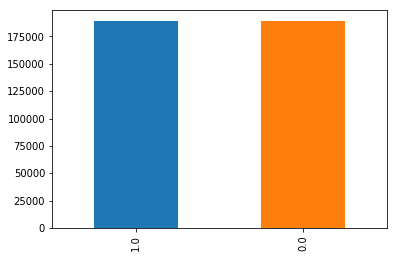

In [598]:
composite_ds['labels'].value_counts().plot.bar()

In [599]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (378616, 28)
Training Labels Shape: (378616,)
Testing Features Shape: (178234, 28)
Testing Labels Shape: (178234,)


In [600]:
# Setup the Random Forest Model with Grid Search to find a good first pass model
rf = RandomForestClassifier(random_state = 42,class_weight="balanced")
parameters = {'n_estimators':[10,50,100,200,500],
              'max_depth':[3,5,7,10]
             }

clf = GridSearchCV(rf, parameters,cv = 3,n_jobs=-1,return_train_score=True,scoring='f1')

In [601]:
# run the model with the training data
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [602]:
# view the CV results
clf.cv_results_

{'mean_fit_time': array([  4.04,  15.13,  26.5 ,  52.32, 130.97,   4.71,  19.77,  37.82,
         78.6 , 196.16,   5.78,  26.22,  52.44, 102.07, 260.64,   9.05,
         35.29,  64.69, 130.5 , 257.85]),
 'std_fit_time': array([ 0.05,  0.53,  0.59,  0.25,  0.51,  0.14,  0.34,  0.41,  0.67,
         1.32,  0.03,  0.38,  1.4 ,  0.93,  1.72,  0.74,  1.78,  1.35,
         0.83, 21.19]),
 'mean_score_time': array([0.25, 0.69, 1.21, 2.27, 5.48, 0.22, 0.67, 1.22, 2.41, 6.54, 0.23,
        0.8 , 1.56, 2.7 , 6.48, 0.26, 0.88, 1.71, 3.38, 5.85]),
 'std_score_time': array([0.03, 0.03, 0.07, 0.03, 0.06, 0.01, 0.03, 0.02, 0.16, 0.63, 0.01,
        0.05, 0.16, 0.06, 0.1 , 0.03, 0.05, 0.02, 0.04, 0.54]),
 'param_max_depth': masked_array(data=[3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 10, 10,
                    10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False

ValueError: x and y must have same first dimension, but have shapes (5,) and (20,)

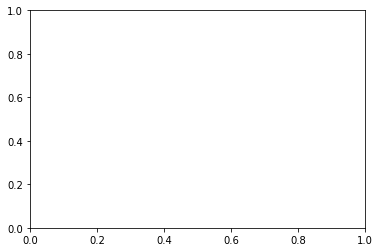

In [603]:
plt.plot(parameters['n_estimators'],clf.cv_results_['mean_test_score'])
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')

In [604]:
rf_best = RandomForestClassifier(random_state = 42,max_depth=7,n_estimators=100)

In [605]:
rf_best.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [606]:
y_pred_rf = rf_best.predict(X_test)

In [607]:
rf_best.score(X_test,y_test)

0.8402044503293423

Normalized confusion matrix
[[0.96 0.04]
 [0.38 0.62]]


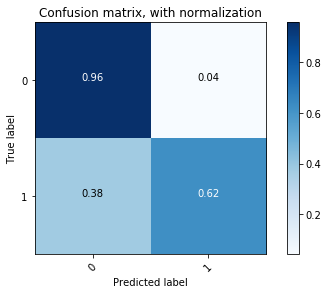

In [608]:
# generate and plot the confusion matrix
cnf_matrix  = confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
title='Confusion matrix, with normalization')

In [609]:
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred_rf)))
print("Recall score: {:.2f}".format(recall_score(y_test, y_pred_rf)))
print("Precision score: {:.2f}".format(precision_score(y_test, y_pred_rf)))

F1 score: 0.73
Recall score: 0.62
Precision score: 0.89


In [64]:
y_pred_naive = np.ones(y_test.shape)

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


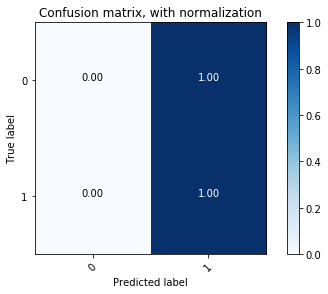

In [65]:
# generate and plot the confusion matrix
cnf_matrix  = confusion_matrix(y_test, y_pred_naive)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
title='Confusion matrix, with normalization')

In [74]:
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred_naive)))
print("Recall score: {:.2f}".format(recall_score(y_test, y_pred_naive)))
print("Precision score: {:.2f}".format(precision_score(y_test, y_pred_naive)))

F1 score: 0.52
Recall score: 1.00
Precision score: 0.35


In [70]:
y_pred_rand = np.random.randint(2,size=y_test.shape)

Normalized confusion matrix
[[0.5 0.5]
 [0.5 0.5]]


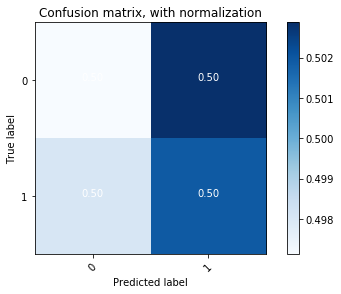

In [72]:
# generate and plot the confusion matrix
cnf_matrix  = confusion_matrix(y_test, y_pred_rand)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
title='Confusion matrix, with normalization')

In [75]:
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred_rand)))
print("Recall score: {:.2f}".format(recall_score(y_test, y_pred_rand)))
print("Precision score: {:.2f}".format(precision_score(y_test, y_pred_rand)))

F1 score: 0.41
Recall score: 0.50
Precision score: 0.35


In [610]:
y_proba_rf = rf_best.predict_proba(X_test)

In [611]:
# compute and ROC curve and AUC_ROC score
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test,y_proba_rf[:,1])

# compute the auc_roc
auc_roc = auc(fpr,tpr)
print("The auc_roc score is {:.2f}".format(auc_roc))

The auc_roc score is 0.86


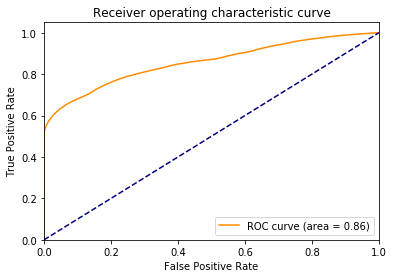

In [612]:
# plot the ROC curve
plt.plot(fpr,tpr,color='darkorange',
        label='ROC curve (area = {:0.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [613]:
feature_importances = pd.DataFrame(rf_best.feature_importances_,
                                   index = X_delayed_AA.columns,
                                    columns=['Importance']).sort_values('Importance',ascending=False)

In [614]:
feature_importances

,Importance
AIR_SYSTEM_DELAY,2.924550e-01
AIRLINE_DELAY,2.918450e-01
LATE_AIRCRAFT_DELAY,1.827780e-01
TAXI_OUT,1.128809e-01
TAXI_IN,3.448801e-02
WEATHER_DELAY,2.131799e-02
WHEELS_OFF,1.209117e-02
DEPARTURE_TIME,1.037988e-02
ARRIVAL_TIME,9.550592e-03
WHEELS_ON,8.652914e-03


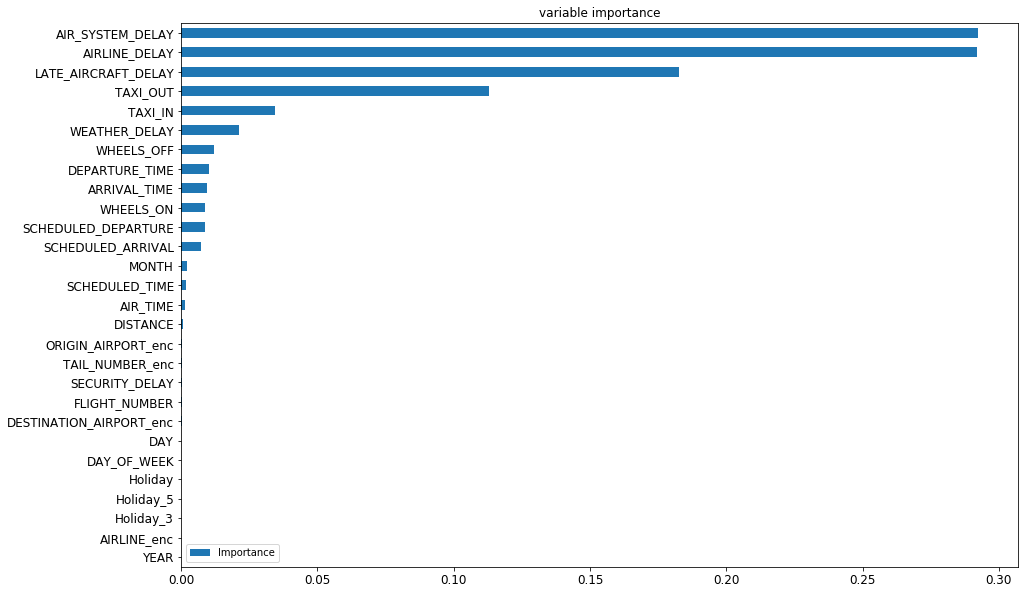

In [615]:
ax = feature_importances[::-1].plot(kind='barh', title ="variable importance", figsize=(15, 10), fontsize=12)

In [617]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [616]:
X_train_scaler = StandardScaler()
X_train_scaler.fit(X_train)
X_train_scaled = X_train_scaler.transform(X_train)

In [ ]:
reg_log = LogisticRegression(C=0.1,penalty='l2')

In [ ]:
reg_log.fit(X_train_scaled,y_train)

In [622]:
X_test_scaled = X_train_scaler.transform(X_test)
y_pred_log = reg_log.predict(X_test_scaled)

In [623]:
reg_log.score(X_test_scaled,y_test)

0.8876701414993772

In [625]:
y_pred_log

array([0., 0., 0., ..., 1., 0., 1.])

Normalized confusion matrix
[[0.92 0.08]
 [0.17 0.83]]


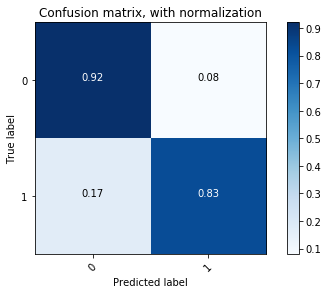

In [626]:
# generate and plot the confusion matrix
cnf_matrix  = confusion_matrix(y_test, y_pred_log)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
title='Confusion matrix, with normalization')

In [627]:
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred_log)))
print("Recall score: {:.2f}".format(recall_score(y_test, y_pred_log)))
print("Precision score: {:.2f}".format(precision_score(y_test, y_pred_log)))

F1 score: 0.84
Recall score: 0.83
Precision score: 0.85


Text(0,0.5,'Features')

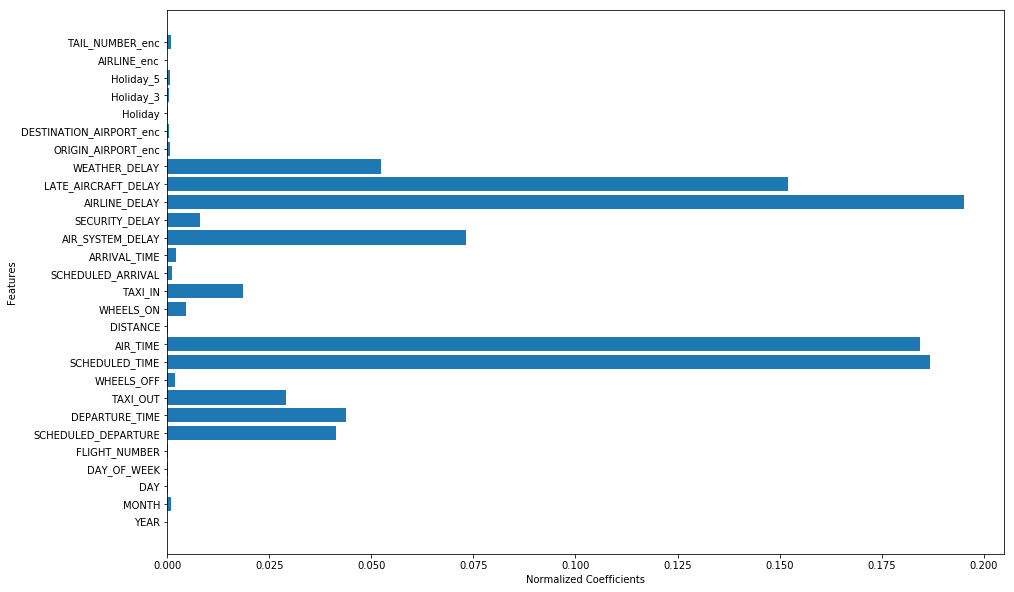

In [632]:
# plot the normalized model coefficients
coefs = np.abs(reg_log.coef_)
coefs = coefs / np.sum(coefs,axis=1)
fig, axes = plt.subplots(1,1,figsize=(15,10))
plt.barh(X_delayed_AA.columns,coefs[0])
plt.xlabel('Normalized Coefficients')
plt.ylabel('Features')